# MLOps Assignment 3: AutoML

## Libraries

In [6]:
# Install H2O
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 4.8 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
import matplotlib.pyplot as plt

In [8]:
# Start H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.27" 2025-04-15; OpenJDK Runtime Environment (build 11.0.27+6-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.27+6-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp_2ldpwfv
  JVM stdout: /tmp/tmp_2ldpwfv/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp_2ldpwfv/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 27 days
H2O_cluster_name:,H2O_from_python_unknownUser_21koo2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## Load and Process the Data

In [2]:
data = pd.read_csv("athletes.csv")

data.head()

,athlete_id,name,region,team,affiliate,gender,age,height,weight,fran,...,snatch,deadlift,backsq,pullups,eat,train,background,experience,schedule,howlong
0,2554.0,Pj Ablang,South West,Double Edge,Double Edge CrossFit,Male,24.0,70.0,166.0,NaN,...,NaN,400.0,305.0,NaN,NaN,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|I r...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
1,3517.0,Derek Abdella,NaN,NaN,NaN,Male,42.0,70.0,190.0,NaN,...,NaN,NaN,NaN,NaN,NaN,I have a coach who determines my programming|I...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
2,4691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5164.0,Abo Brandon,Southern California,LAX CrossFit,LAX CrossFit,Male,40.0,67.0,NaN,211.0,...,200.0,375.0,325.0,25.0,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|,4+ years|
4,5286.0,Bryce Abbey,NaN,NaN,NaN,Male,32.0,65.0,149.0,206.0,...,150.0,NaN,325.0,50.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I inc...,I played college sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I strictly s...,1-2 years|


In [3]:
# clean data and store original copy
data_cp = data.copy()

# remove not relevant columns
data_cp = data_cp.dropna(subset=['region','age','weight','height','howlong','gender','eat',
                                 'train','background','experience','schedule','howlong',
                                 'deadlift','candj','snatch','backsq','experience',
                                 'background','schedule','howlong'])
data_cp = data_cp.drop(columns=['affiliate','team','name','fran','helen','grace',
                                'filthy50','fgonebad','run400','run5k','pullups','train'])

# remove Outliers
data_cp = data_cp[data_cp['weight'] < 1500]
data_cp = data_cp[data_cp['gender'] != '--']
data_cp = data_cp[data_cp['age'] >= 18]
data_cp = data_cp[(data_cp['height'] < 96) & (data_cp['height'] > 48)]

data_cp = data_cp[
    ((data_cp['gender'] == 'Male') & (data_cp['deadlift'] > 0) & (data_cp['deadlift'] <= 1105)) |
    ((data_cp['gender'] == 'Female') & (data_cp['deadlift'] > 0) & (data_cp['deadlift'] <= 636))
]
data_cp = data_cp[(data_cp['candj'] > 0) & (data_cp['candj'] <= 395)]
data_cp = data_cp[(data_cp['snatch'] > 0) & (data_cp['snatch'] <= 496)]
data_cp = data_cp[(data_cp['backsq'] > 0) & (data_cp['backsq'] <= 1069)]

# clean Survey Data
decline_dict = {'Decline to answer|': np.nan}
data_cp = data_cp.replace(decline_dict)
data_cp = data_cp.dropna(subset=['background','experience','schedule','howlong','eat'])

In [4]:
# create new features

# calculate total lift
data_cp["total_lift"] = (data_cp["deadlift"] + data_cp["candj"] +
                         data_cp["snatch"] + data_cp["backsq"])

# create relative lift cols
data_cp['candj_rel'] = data_cp['candj'] / data_cp['weight']
data_cp['snatch_rel'] = data_cp['snatch'] / data_cp['weight']
data_cp['deadlift_rel'] = data_cp['deadlift'] / data_cp['weight']
data_cp['backsq_rel'] = data_cp['backsq'] / data_cp['weight']

# create bmi cols
data_cp['BMI'] = (data_cp['weight'] * 703) / (data_cp['height'] ** 2)

# only retain final relevant cols
data_cp = data_cp[['gender', 'age', 'height', 'weight', 'total_lift', 'candj_rel', 'snatch_rel', 'deadlift_rel', 'backsq_rel', 'BMI']]

In [5]:
data_cp.head()

,gender,age,height,weight,total_lift,candj_rel,snatch_rel,deadlift_rel,backsq_rel,BMI
21,Male,30.0,71.0,200.0,1110.0,1.175000,0.875000,1.925000,1.575000,27.891291
22,Male,28.0,70.0,176.0,910.0,1.062500,0.761364,1.903409,1.443182,25.250612
27,Male,35.0,68.0,225.0,1335.0,1.266667,0.911111,1.955556,1.800000,34.207396
50,Male,36.0,71.0,199.0,1354.0,1.341709,1.065327,2.437186,1.959799,27.751835
60,Male,36.0,64.0,155.0,1225.0,1.580645,1.161290,2.677419,2.483871,26.602783


### Target Variable: Total Lift

(Note: cleaning and new features are based on HW 2)

## H20 AutoML: All Features

In [23]:
# convert to h2o df
hf = h2o.H2OFrame(data_cp)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [24]:
# train-test split 80-20%
target = 'total_lift'

features = hf.columns
features.remove(target)

train, test = hf.split_frame(ratios = [.8], seed = 7)

In [25]:
# run the H20 automl
# times out after 2 minutes
aml = H2OAutoML(max_runtime_secs = 120, seed = 7)
aml.train(x = features, y = target, training_frame = train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/3
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None
Custom metalearner hyperparameters,None


In [26]:
# top 10 models
lb = aml.leaderboard
print(lb.head(rows = 10))

model_id                                                    rmse       mse       mae        rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_1_AutoML_3_20250724_205848  19.0292   362.111   9.01995    0.0647092                   362.111
StackedEnsemble_BestOfFamily_2_AutoML_3_20250724_205848  19.399    376.32    9.00577    0.0646813                   376.32
StackedEnsemble_AllModels_1_AutoML_3_20250724_205848     19.5222   381.115   9.01015    0.0646616                   381.115
GBM_1_AutoML_3_20250724_205848                           20.0148   400.594   9.77344    0.0664876                   400.594
XGBoost_1_AutoML_3_20250724_205848                       22.6614   513.538  14.1906   nan                           513.538
XGBoost_2_AutoML_3_20250724_205848                       30.3938   923.786  21.0409     0.0596049                   923.786
DeepLearning_1_AutoML_3_20250724_205848                  33.7582  1139.62   17.9062     0.0676869                  1139.62
DRF_1_Auto

### Data Insights

The H2O AutoML run highlights that stacked ensemble models deliver the best performance, with the BestOfFamily ensemble achieving the lowest RMSE of approximately 19.03. These models outperform individual base learners like GBM and XGBoost, which have higher errors, reinforcing the value of model ensembling in capturing complex patterns in the data. Interestingly, XGBoost models show relatively higher RMSE values, suggesting they may not generalize as well in this context. While tree-based models like DRF and GBM are also included, their performance lags behind the ensembles. Overall, H2O AutoML confirms that ensemble-based approaches are best suited for this dataset, effectively balancing predictive power with model robustness.

## Top 5 Features

Top 5 Features:
       variable  relative_importance
0        gender         3.438224e+09
1        weight         1.749409e+09
2    backsq_rel         1.353025e+09
3  deadlift_rel         8.942570e+08
4     candj_rel         7.719451e+08


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


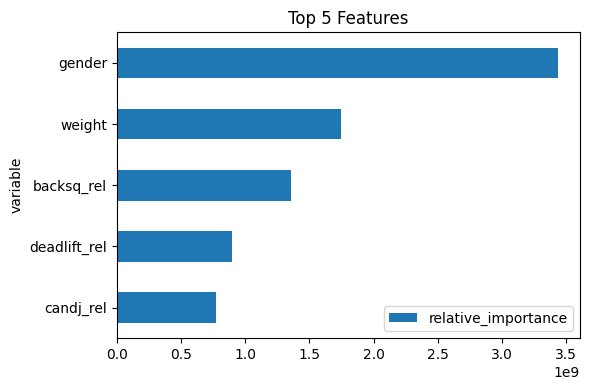

In [27]:
lb = aml.leaderboard.as_data_frame()

# Get the top GBM model (or any model with varimp) --> can't get features from stacked ensembles
best_gbm_id = lb[lb.model_id.str.contains("GBM")].iloc[0].model_id
best_gbm = h2o.get_model(best_gbm_id)

# get top 5 features
varimp = best_gbm.varimp(use_pandas=True)
top5 = varimp.head(5)
print("Top 5 Features:")
print(top5[['variable', 'relative_importance']])

top5.plot(kind = "barh", x = "variable", y = "relative_importance", figsize = (6, 4), title = "Top 5 Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

The top 5 features in order of importance are gender, weight, relative backsquat, relative deadlift, and relative candj.

## H20 AutoML: Top 3 Features

In [31]:
# retain target + top 3 features
data_cp_3 = data_cp[['gender', 'weight', 'backsq_rel', 'total_lift']]

hf_3 = h2o.H2OFrame(data_cp_3)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [32]:
# train-test split 80-20%
target = 'total_lift'

features2 = hf_3.columns
features2.remove(target)

train2, test2 = hf_3.split_frame(ratios = [.8], seed = 7)

In [34]:
# run the H20 automl
# times out after 2 minutes
aml2 = H2OAutoML(max_runtime_secs = 120, seed = 7)
aml2.train(x = features2, y = target, training_frame = train2)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/6
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),0/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


## Model Comparisons

In [29]:
top_3_by_rmse = lb.sort_values(by='rmse').head(3)
print("All Features: Top 3 models by validation RMSE:")
print(top_3_by_rmse[['model_id', 'rmse']])

All Features: Top 3 models by validation RMSE:
                                            model_id       rmse
0  StackedEnsemble_BestOfFamily_1_AutoML_3_202507...  19.029206
1  StackedEnsemble_BestOfFamily_2_AutoML_3_202507...  19.398979
2  StackedEnsemble_AllModels_1_AutoML_3_20250724_...  19.522171


In [35]:
lb2 = aml2.leaderboard.as_data_frame()

top_3_by_rmse2 = lb2.sort_values(by='rmse').head(3)
print("Top 3 Features: Top 3 models by validation RMSE:")
print(top_3_by_rmse2[['model_id', 'rmse']])

Top 3 Features: Top 3 models by validation RMSE:
                                            model_id       rmse
0  StackedEnsemble_BestOfFamily_3_AutoML_4_202507...  66.910588
1  StackedEnsemble_AllModels_2_AutoML_4_20250724_...  66.975930
2                     GBM_2_AutoML_4_20250724_210545  67.025465


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
